## Подготовка к задаче
- Каждому письму из набора писем (поле Content в файле mails.csv) проставлен класс (поле class). Все ФИО, названия, направления подготовки, специальности в письмах – сгенерированые. 
- Набор писем необходимо классифицировать, для этого необходимо датасет разбить на тренировочное/валидацонное (при необходимости)/тестовое множества, при этом количество записей в тестовом множестве должно составлять 10% от объема исходного датасета и необходимо сохранить пропорции классов в выборках (параметр stratify).

In [60]:
import re
import random
import numpy as np
import itertools

import pandas as pd
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 11)

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.cm as cm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

In [61]:
# Модуль для анализа слов в предложении.
%pip install pymorphy3
import pymorphy3

Note: you may need to restart the kernel to use updated packages.


In [62]:
gc_path = r""
df = pd.read_excel(gc_path+'mails.xlsx')
print(f"{df['class'].unique()=}")
print(f"{df['TYPE_HOTLINE'].unique()=}")

df['class'].unique()=array([1, 6, 5, 2, 3, 4, 8, 7])
df['TYPE_HOTLINE'].unique()=array([2, 1, 3])


In [63]:
df.head(2)


,CONTENT,TYPE_HOTLINE,class
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6


In [64]:
# Меняем наименование столбца только для удобства
df.rename(columns={'CLASS_': 'lbl'}, inplace=True)
# Для удобства добавляем два столбца с наименованиями классов и каналов поствупления обращений.
cls_dic = {1:['Условия подачи','Условия подачи документов, сроки, документы, места, льготы'],
           2:['Проходной и допустимый балл','Минимальный проходной балл и Минимальный балл для подачи заявления'],
           3:['Достижения','Индивидуальные достижения.'],
           4:['Общежития','Общежития'],
           5:['Вступительные испытания','Вступительные испытания, экзамены, кто может поступать и сдавать экзамены'],
           6:['Перевод','Перевод с направления на направление'],
           7:['Аспирантура','Вопросы по аспирантуре'],
           8:['Регистрация','Регистрация в электронных системах'],
           }
hlt_dic = {1:'ONLINE приёмная',
           2:'Очная приемная',
           3:'Приёмная аспирантуры'
           }

df['cls_name'] = df['class'].map(lambda x: cls_dic[x][0])
df['hlt_name'] = df.TYPE_HOTLINE.map(lambda x: hlt_dic[x])
df.head()

,CONTENT,TYPE_HOTLINE,class,cls_name,hlt_name
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1,Условия подачи,Очная приемная
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6,Перевод,Очная приемная
2,Здравствуйте! Скажите пожалуйста могу ли я под...,2,1,Условия подачи,Очная приемная
3,Здравствуйте! Где взять и куда подать заявлени...,2,1,Условия подачи,Очная приемная
4,Здравствуйте! Есть два высших образования (пла...,2,1,Условия подачи,Очная приемная


In [65]:
cls_list = []
for i in range(1, len(cls_dic)+1):
  cls_list.append(cls_dic[i][0])
cls_list

['Условия подачи',
 'Проходной и допустимый балл',
 'Достижения',
 'Общежития',
 'Вступительные испытания',
 'Перевод',
 'Аспирантура',
 'Регистрация']

In [66]:
df.shape

(588, 5)

In [67]:
g = df.groupby('cls_name')['cls_name'].count().sort_values()
print(g)

cls_name
Аспирантура                      5
Регистрация                     16
Проходной и допустимый балл     24
Общежития                       28
Достижения                      29
Перевод                         42
Вступительные испытания        155
Условия подачи                 289
Name: cls_name, dtype: int64


In [68]:
g = df.groupby('TYPE_HOTLINE')['TYPE_HOTLINE'].count().sort_values()
g

TYPE_HOTLINE
3      6
1     45
2    537
Name: TYPE_HOTLINE, dtype: int64

Задача 1. Подготовка данных

In [69]:
bad_dict = {
    'мочь',
    # 'сказать',
    # 'подсказать',
    # 'быть',
    "хотеть",
    "хотеться",
    # "есть",
    "узнать",
    "знать",
    "вопрос",
    "уточнить",
    "уважние",
}

def morphan(word, morph):
    '''
    Приведение слов в нормальную форму, удаление числительных и ФИО.
    '''
    word = word.strip()  # Удаляет пробелы до и после слова
    p = morph.parse(word)[0]  # Разбираем (анализируем) слово с pymorphy3

    word_new = word
    if (not 'Surn' in p.tag) and (not 'Name' in p.tag) and (not 'Patr' in p.tag) and ('NOUN' in p.tag):
        #существительное не ФИО
        word_new = p.normal_form
    elif 'Surn' in p.tag:
        # word_new = 'ФАМИЛИЯ'
        word_new = ''
    elif 'Name' in p.tag:
        # word_new = 'ИМЯ'
        word_new = ''
    elif 'Patr' in p.tag:
        # word_new = 'ОТЧЕСТВО'
        word_new = ''


    elif ('INFN' in p.tag) or ('VERB' in p.tag): #глагол
        word_new = p.normal_form

    elif ('ADJF' in p.tag) or ('ADJS' in p.tag) or ('COMP' in p.tag): #прилагательное
        # word_new = p.normal_form
        word_new = ''

    elif ('PRTF' in p.tag) or ('PRTS' in p.tag) or ('GRND' in p.tag): #причастие, похоже на глагол
        # word_new = p.normal_form
        word_new = ''

    elif ('ADVB' in p.tag) or ('NPRO' in p.tag) or ('PRED' in p.tag):
        # предлоги, местоимения и пр.
        # word_new = p.normal_form
        word_new = ''

    elif ('PREP' in p.tag) or ('CONJ' in p.tag) or ('PRCL' in p.tag) or ('INTJ' in p.tag):
        word_new = ''

    elif ('NUMR' in p.tag) or ('NUMB' in p.tag) or ('intg' in p.tag) or ('ROMN' in p.tag) or ('UNKN' in p.tag): # числительные NUMB, межометия intg
        word_new = ''

    else:
        word_new = word

    if word_new in bad_dict:
        word_new = ''
    return word_new

def normtext(txt, morph):
    '''
    Возвращает текст из слов в нормальной форме
    '''
    txt = re.sub(r"[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+", ' ', txt)  # заменяем знаки пунктуаци и спецсиволы на пробелы
    return str(' '.join([morphan(x, morph) for x in txt.split()]))

In [70]:
morph = pymorphy3.MorphAnalyzer()
normtext('Расскажите, пожалуйста, Иван Васильевич, какие условия поступления в 2025 году?', morph)

'рассказать     условие поступление   год'

In [71]:
df['text'] = df.CONTENT.map(lambda x: normtext(x, morph))


In [72]:
# Сохраняем обработанные данные
df.to_excel(gc_path+r'df_prep.xlsx', index=False)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)

tfv = TfidfVectorizer()  # Функция получения векторного представления
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

param_grid = {'C': [1.,10.0]}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

grid_search.best_params_

{'C': 10.0}

In [74]:
def classifier(X_train, y_train, C=10.):
    '''
    Возвращает обученный классификатор и векторизатор.
    '''

    tfv = TfidfVectorizer()
    X_train = tfv.fit_transform(X_train)

    clf = LogisticRegression(C=C)
    clf = clf.fit(X_train, y_train)

    return tfv, clf

def predictor(text, clf, tfv):
    '''
    text - классифицируемый текс
    clf - обученный классификатор
    tfv - обученный векторизатор

    '''
    X_test = tfv.transform([text])

    pred = clf.predict(X_test)

    return pred[0]

In [75]:
# Обучение
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
tfv, clf = classifier(X_train, y_train, C=10.0)

In [76]:
# Предсказание
pred_save = []
class_save = []
pred = []
for nom, txt in enumerate(X_test.values):
    pred.append(predictor(txt, clf, tfv))

In [77]:
y_test_list = y_test.tolist()
y_test_list.extend(class_save)
pred_list = pred[:]
pred_list.extend(pred_save)

mtrs = classification_report([cls_dic[x][0] for x in y_test_list], [cls_dic[x][0] for x in pred_list])
print(mtrs)

                             precision    recall  f1-score   support

                Аспирантура       0.00      0.00      0.00         1
    Вступительные испытания       0.98      0.88      0.92        49
                 Достижения       0.67      0.50      0.57         8
                  Общежития       0.45      1.00      0.62         5
                    Перевод       1.00      0.17      0.29         6
Проходной и допустимый балл       0.89      0.73      0.80        11
                Регистрация       1.00      0.25      0.40         8
             Условия подачи       0.83      0.97      0.89        89

                   accuracy                           0.84       177
                  macro avg       0.73      0.56      0.56       177
               weighted avg       0.86      0.84      0.83       177



d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

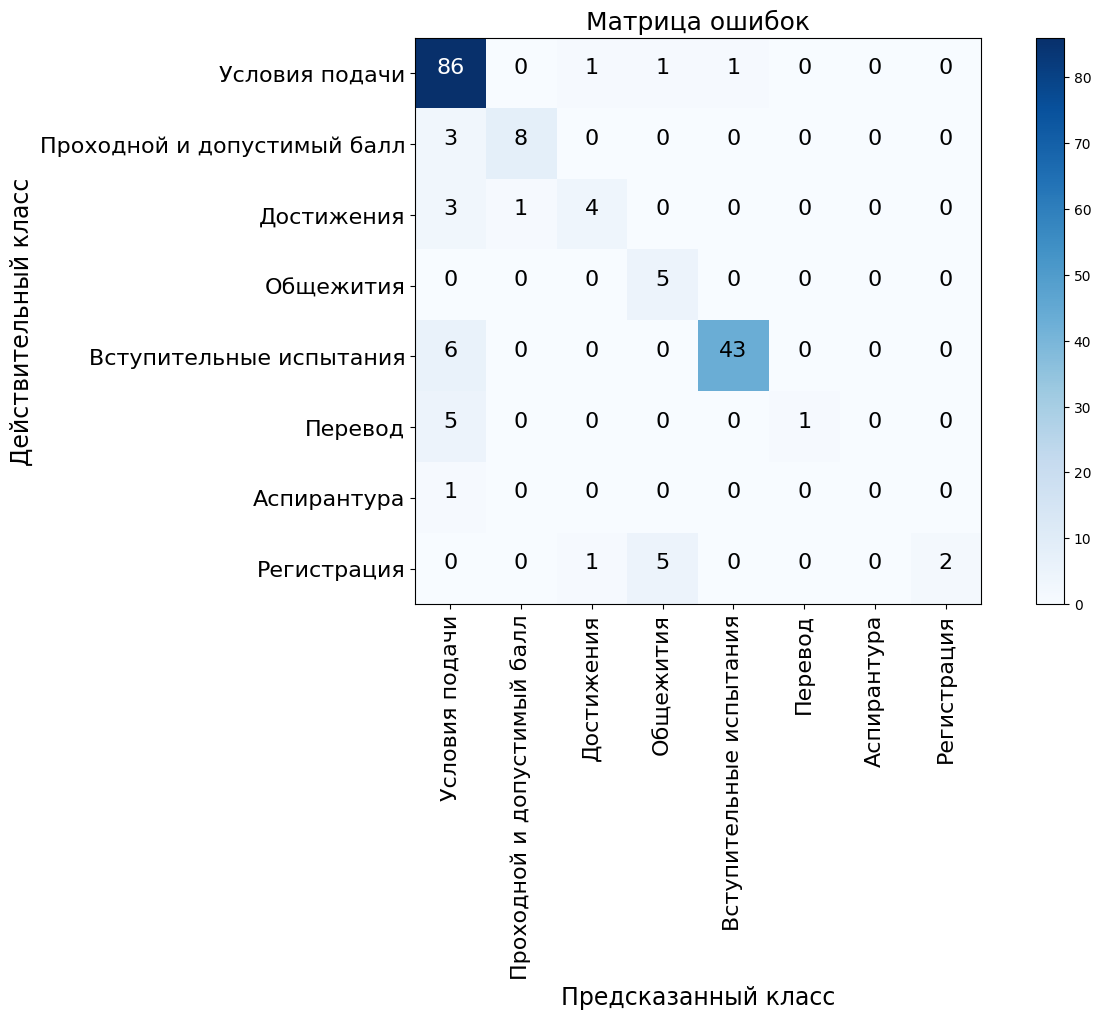

In [78]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size - 6)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout()
    plt.ylabel('Действительный класс', fontsize=f_size + 1)
    plt.xlabel('Предсказанный класс', fontsize=f_size + 1)
    plt.show()

# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y_test_list, pred_list)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

In [79]:
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM

In [80]:
# создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(X_train)

In [81]:
X_train_1, X_vt_1, y_train_1, y_vt_1 = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_vt_1, y_vt_1, test_size=0.5, random_state=42)

In [82]:
# Максимальное количество слов в самом длинном письме
max_words = 0
for desc in df.text.tolist():
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальное количество слов в самом длинном письме: {} слов'.format(max_words))

total_unique_words = len(tokenizer.word_counts)
print('Всего уникальных слов в словаре: {}'.format(total_unique_words))

maxSequenceLength = max_words


Максимальное количество слов в самом длинном письме: 45 слов
Всего уникальных слов в словаре: 791


In [83]:
# Преобразуем описания заявок в векторы чисел
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.text)

X_train = tokenizer.texts_to_sequences(X_train_1)
X_valid = tokenizer.texts_to_sequences(X_valid_1)
X_test = tokenizer.texts_to_sequences(X_test_1)

X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_valid:', X_valid.shape)
print('Размерность X_test:', X_test.shape)

# Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)

num_classes = df['class'].unique().shape[0]+1

y_train = keras.utils.to_categorical(y_train_1, num_classes)
y_valid = keras.utils.to_categorical(y_valid_1, num_classes)
y_test = keras.utils.to_categorical(y_test_1, num_classes)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

Размерность X_train: (411, 45)
Размерность X_valid: (88, 45)
Размерность X_test: (89, 45)
y_train shape: (411, 9)
y_valid shape: (88, 9)
y_test shape: (89, 9)


In [84]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [85]:
batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.2906 - loss: 2.1753 - val_accuracy: 0.4886 - val_loss: 2.0758
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5179 - loss: 2.0008 - val_accuracy: 0.5000 - val_loss: 1.6424
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5313 - loss: 1.6224 - val_accuracy: 0.5000 - val_loss: 1.4627
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4931 - loss: 1.4956 - val_accuracy: 0.5000 - val_loss: 1.4282
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5099 - loss: 1.4067 - val_accuracy: 0.5000 - val_loss: 1.4061
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5090 - loss: 1.4695 - val_accuracy: 0.5114 - val_loss: 1.3533
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5525 - loss: 1.3610 - val_accuracy: 0.6250 - val_loss: 1.2833
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6381 - loss: 1.2692 - va

In [86]:
predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step


In [87]:
print(classification_report(y2, pred2))

              precision    recall  f1-score   support

           1       0.76      0.93      0.84        45
           2       0.00      0.00      0.00         3
           3       0.25      0.25      0.25         4
           4       0.40      1.00      0.57         2
           5       0.86      0.76      0.81        25
           6       0.33      0.25      0.29         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.73        89
   macro avg       0.33      0.40      0.34        89
weighted avg       0.66      0.73      0.69        89



d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

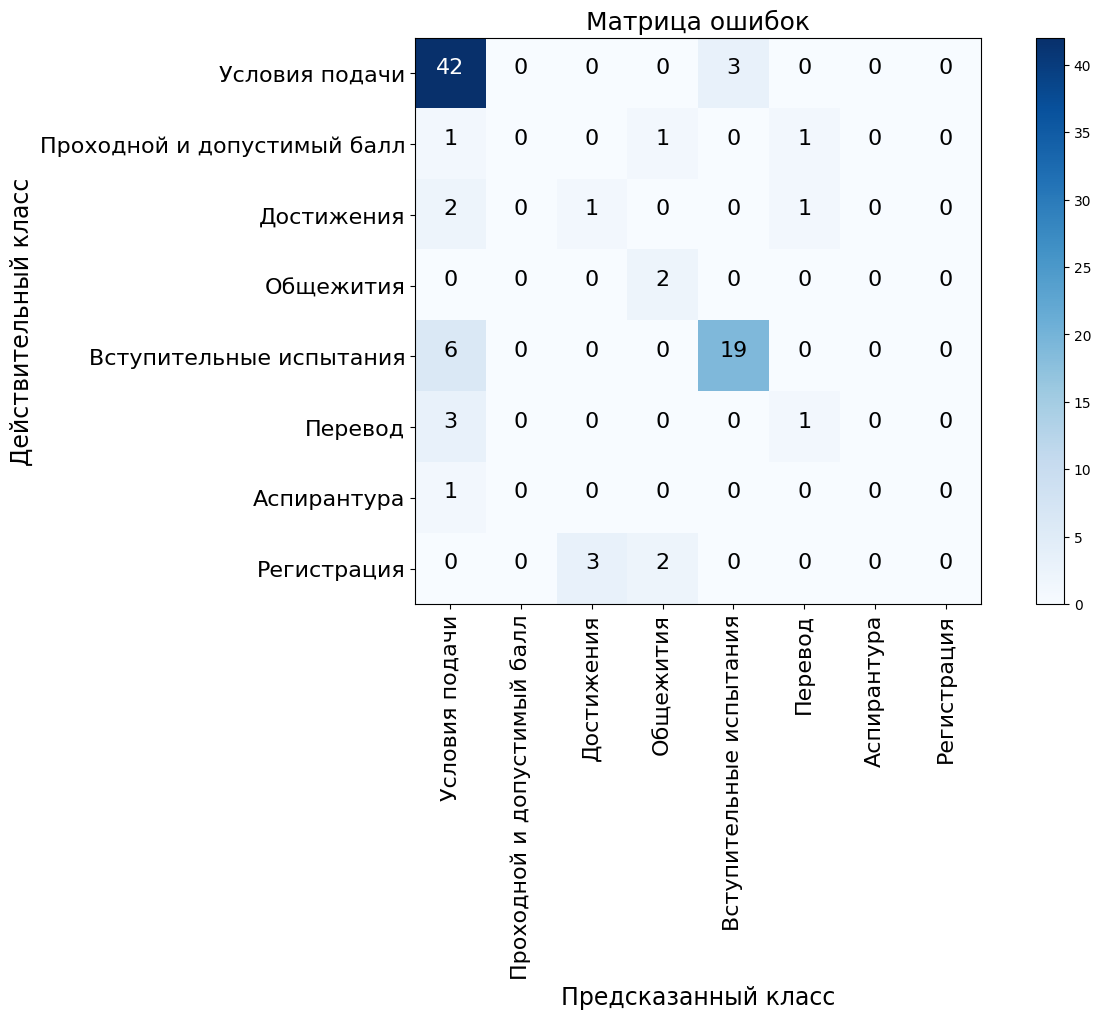

In [88]:
# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.3677 - loss: 2.1394 - val_accuracy: 0.5000 - val_loss: 1.8190
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4992 - loss: 1.7081 - val_accuracy: 0.5000 - val_loss: 1.4545
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4682 - loss: 1.5067 - val_accuracy: 0.5000 - val_loss: 1.4417
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5158 - loss: 1.3747 - val_accuracy: 0.5000 - val_loss: 1.4309
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5121 - loss: 1.4045 - val_accuracy: 0.5000 - val_loss: 1.4163
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4753 - loss: 1.3943 - val_accuracy: 0.5000 - val_loss: 1.3996
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4846 - loss: 1.3679 - val_accuracy: 0.5000 - val_loss: 1.3572
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4882 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

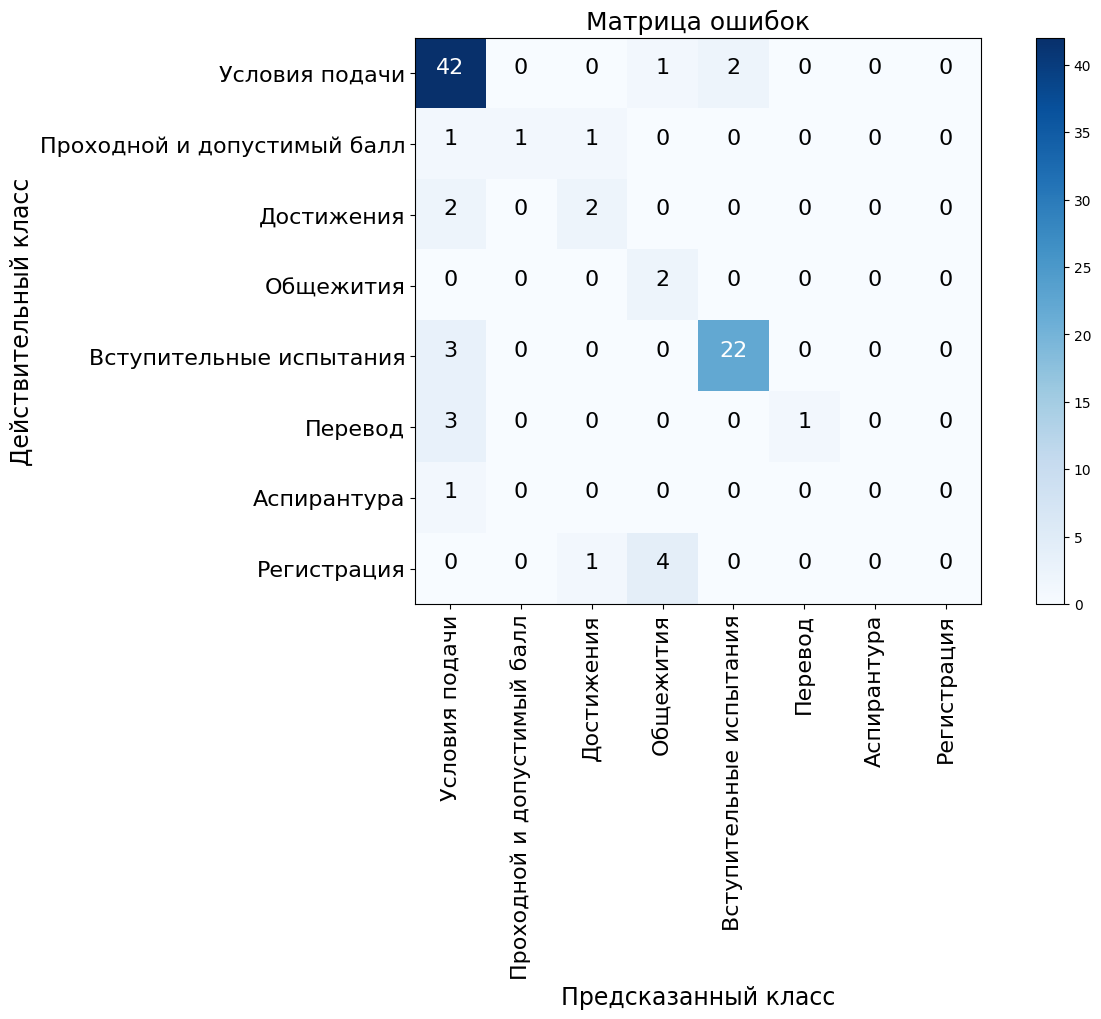

In [89]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.4095 - loss: 2.1514 - val_accuracy: 0.5000 - val_loss: 1.9178
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4888 - loss: 1.8092 - val_accuracy: 0.5000 - val_loss: 1.6007
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4535 - loss: 1.6239 - val_accuracy: 0.5000 - val_loss: 1.5016
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4922 - loss: 1.4377 - val_accuracy: 0.5000 - val_loss: 1.4514
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4825 - loss: 1.4400 - val_accuracy: 0.5341 - val_loss: 1.3819
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5268 - loss: 1.3476 - val_accuracy: 0.6023 - val_loss: 1.2990
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6246 - loss: 1.3013 - val_accuracy: 0.6250 - val_loss: 1.2088
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6746 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

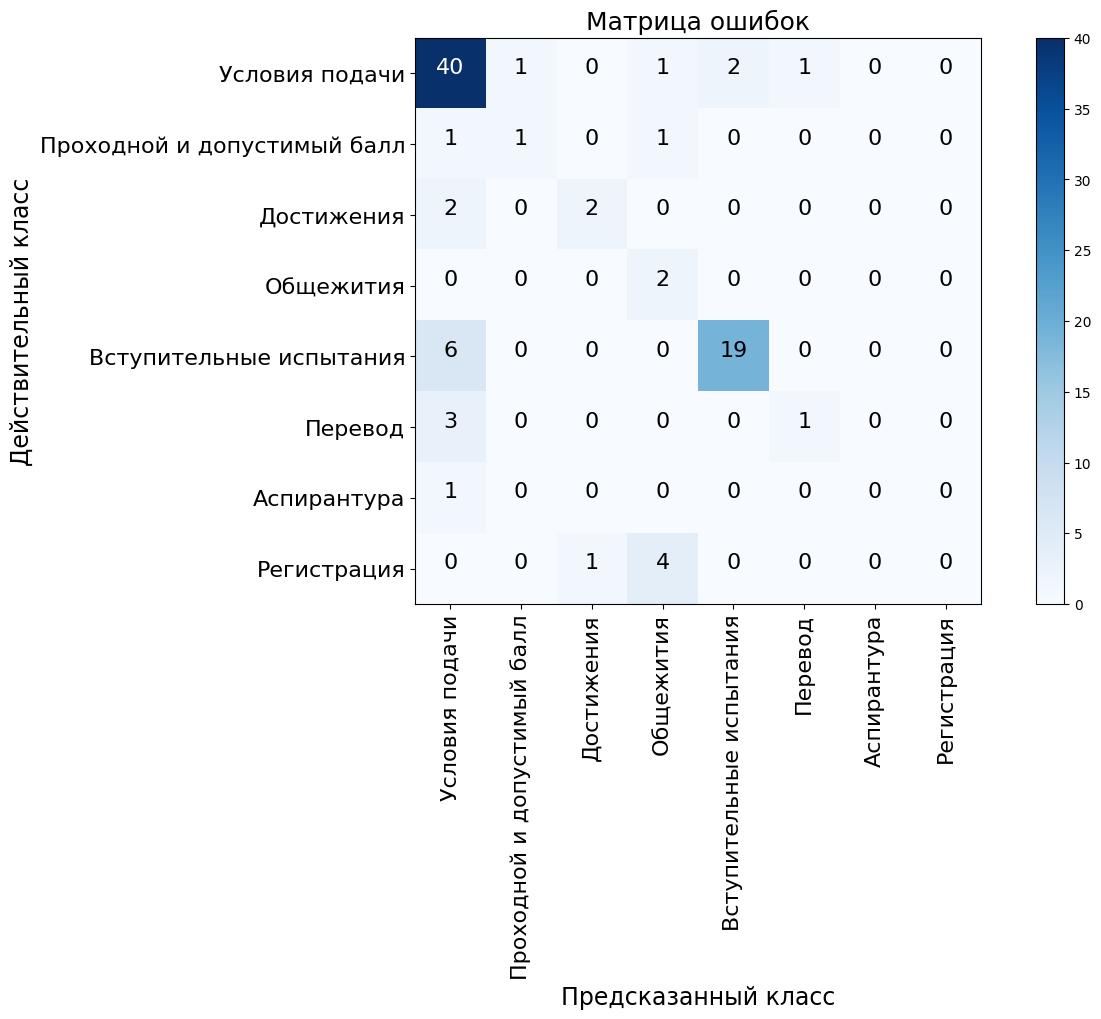

In [90]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.3671 - loss: 2.1228 - val_accuracy: 0.5000 - val_loss: 1.7352
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4832 - loss: 1.6962 - val_accuracy: 0.5000 - val_loss: 1.5043
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5143 - loss: 1.5227 - val_accuracy: 0.5000 - val_loss: 1.4735
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5050 - loss: 1.4701 - val_accuracy: 0.5000 - val_loss: 1.4570
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5274 - loss: 1.3683 - val_accuracy: 0.5000 - val_loss: 1.4219
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5040 - loss: 1.3955 - val_accuracy: 0.5227 - val_loss: 1.3769
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5263 - loss: 1.3542 - val_accuracy: 0.5795 - val_loss: 1.3076
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6083 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

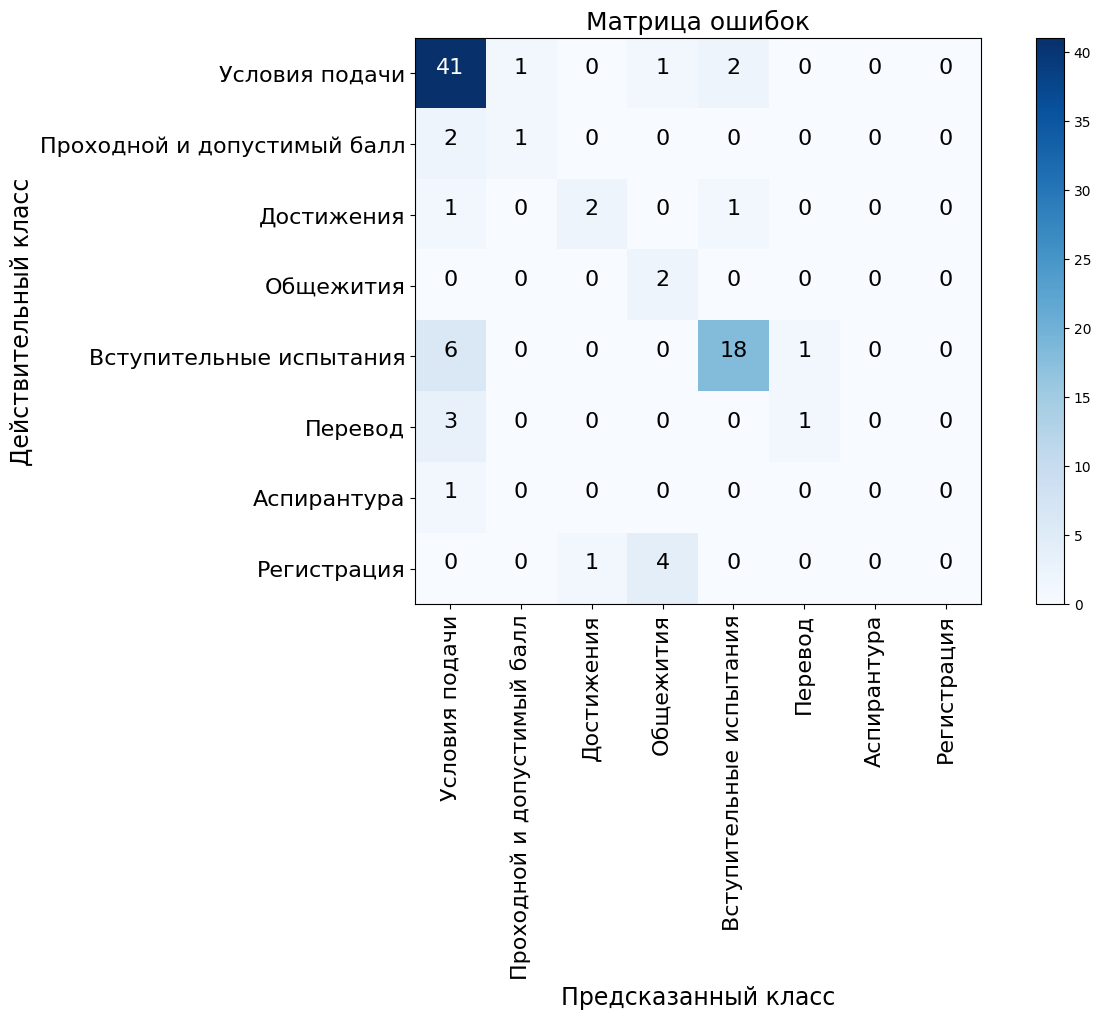

In [91]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.3669 - loss: 2.1610 - val_accuracy: 0.5000 - val_loss: 2.0098
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5082 - loss: 1.9132 - val_accuracy: 0.5000 - val_loss: 1.6227
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5045 - loss: 1.5728 - val_accuracy: 0.5000 - val_loss: 1.5014
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4580 - loss: 1.5025 - val_accuracy: 0.5000 - val_loss: 1.4486
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5222 - loss: 1.4100 - val_accuracy: 0.5000 - val_loss: 1.4165
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5196 - loss: 1.4077 - val_accuracy: 0.5000 - val_loss: 1.3741
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5281 - loss: 1.4154 - val_accuracy: 0.5568 - val_loss: 1.3119
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5428 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

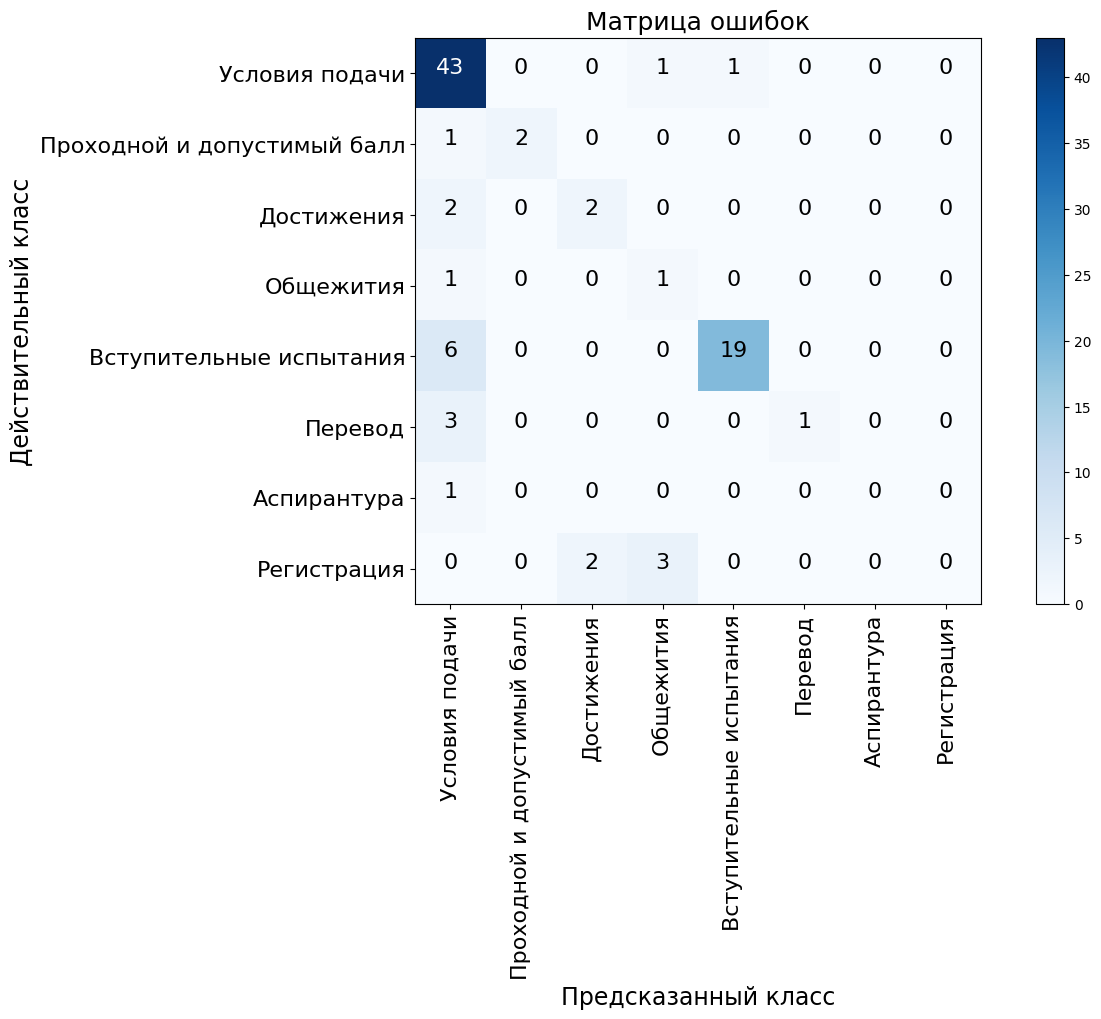

In [92]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(25, dropout=0.1, recurrent_dropout=0.25))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.3926 - loss: 2.1478 - val_accuracy: 0.5000 - val_loss: 1.8791
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4755 - loss: 1.7165 - val_accuracy: 0.5000 - val_loss: 1.5737
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4994 - loss: 1.4941 - val_accuracy: 0.5000 - val_loss: 1.5103
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4996 - loss: 1.4205 - val_accuracy: 0.5000 - val_loss: 1.4801
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4706 - loss: 1.4879 - val_accuracy: 0.5000 - val_loss: 1.4557
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5124 - loss: 1.3625 - val_accuracy: 0.5000 - val_loss: 1.4116
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4903 - loss: 1.2944 - val_accuracy: 0.5000 - val_loss: 1.3676
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5203 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

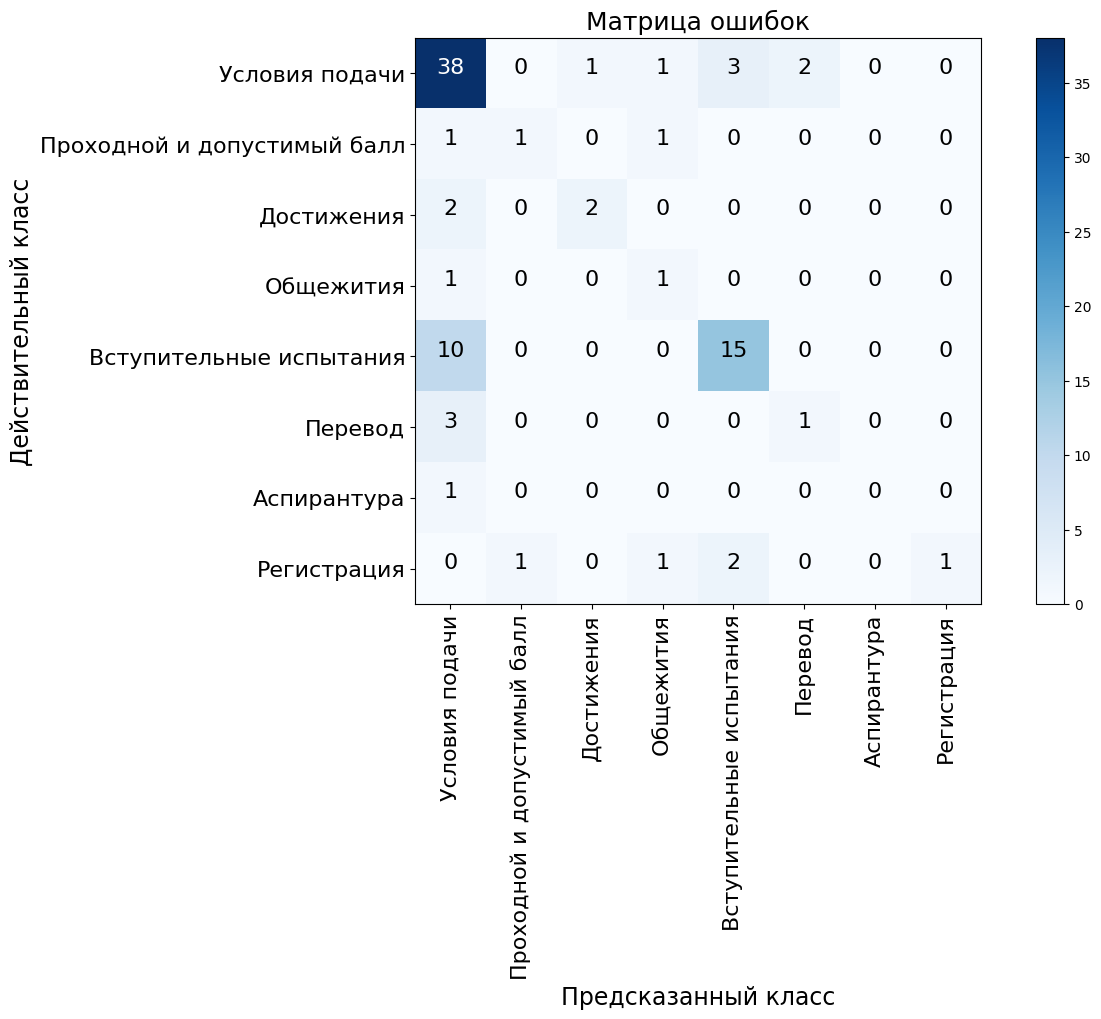

In [93]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='lion',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.2516 - loss: 2.1886 - val_accuracy: 0.5227 - val_loss: 2.1498
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5060 - loss: 2.1392 - val_accuracy: 0.5114 - val_loss: 2.0798
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4973 - loss: 2.0493 - val_accuracy: 0.5000 - val_loss: 1.9210
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5004 - loss: 1.8746 - val_accuracy: 0.5000 - val_loss: 1.6329
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5060 - loss: 1.5937 - val_accuracy: 0.5000 - val_loss: 1.4990
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4885 - loss: 1.5151 - val_accuracy: 0.5000 - val_loss: 1.4630
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4813 - loss: 1.4946 - val_accuracy: 0.5000 - val_loss: 1.4460
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4815 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

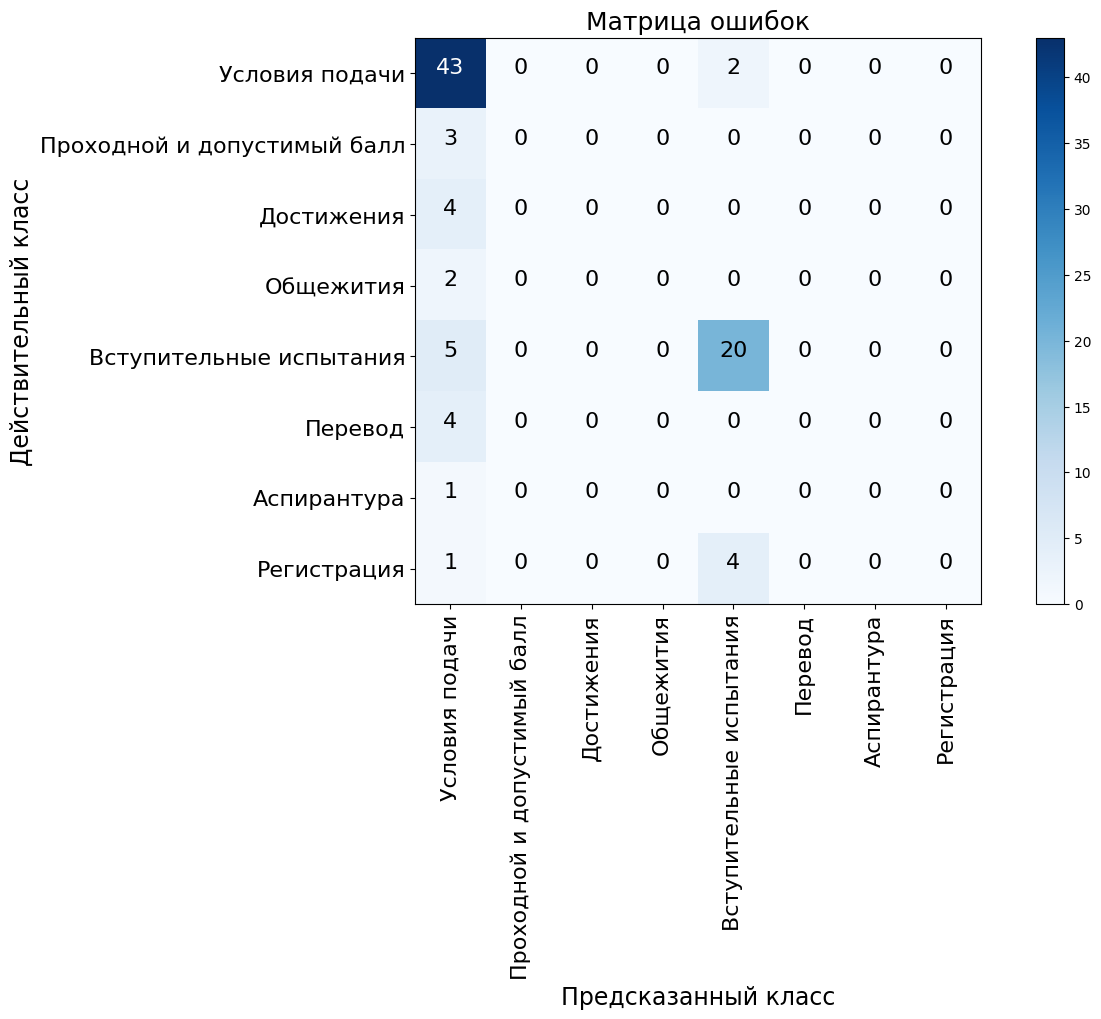

In [94]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.3395 - loss: 2.1769 - val_accuracy: 0.5000 - val_loss: 2.1147
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5235 - loss: 2.0956 - val_accuracy: 0.5000 - val_loss: 2.0392
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4969 - loss: 2.0228 - val_accuracy: 0.5000 - val_loss: 1.9682
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4856 - loss: 1.9641 - val_accuracy: 0.5000 - val_loss: 1.9010
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4867 - loss: 1.8871 - val_accuracy: 0.5000 - val_loss: 1.8384
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4641 - loss: 1.8284 - val_accuracy: 0.5000 - val_loss: 1.7797
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5137 - loss: 1.7449 - val_accuracy: 0.5000 - val_loss: 1.7275
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4769 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

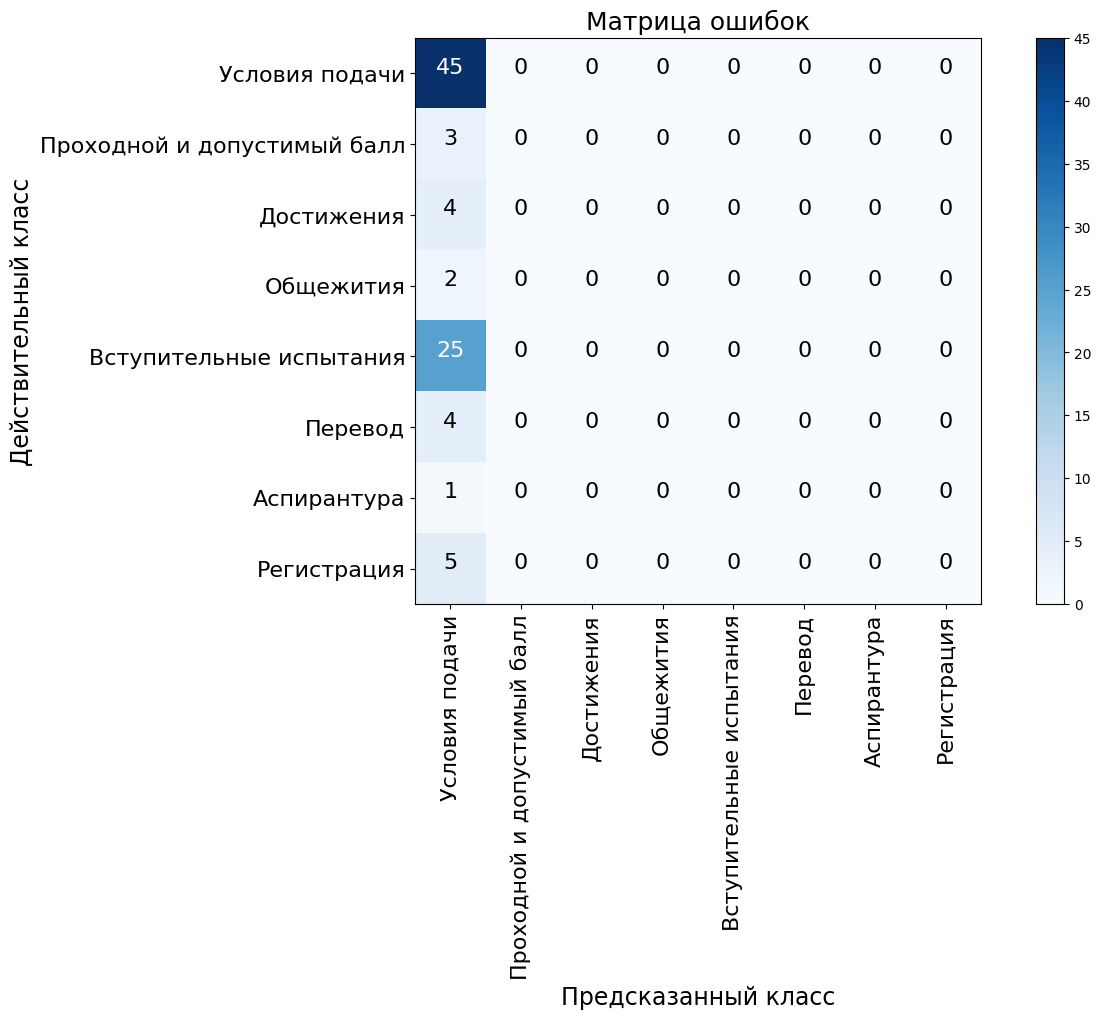

In [95]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.2109 - loss: 6.8409 - val_accuracy: 0.0341 - val_loss: 2.3744
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0633 - loss: 3.3902 - val_accuracy: 0.0341 - val_loss: 6.8450
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.0575 - loss: 11.8161 - val_accuracy: 0.0341 - val_loss: 14.1018
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.0700 - loss: 13.8785 - val_accuracy: 0.0341 - val_loss: 13.2737
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.0626 - loss: 13.1148 - val_accuracy: 0.0341 - val_loss: 13.1970
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0794 - loss: 12.5102 - val_accuracy: 0.0227 - val_loss: 12.8943
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.1004 - loss: 9.5847 - val_accuracy: 0.0227 - val_loss: 3.6883
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy:

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

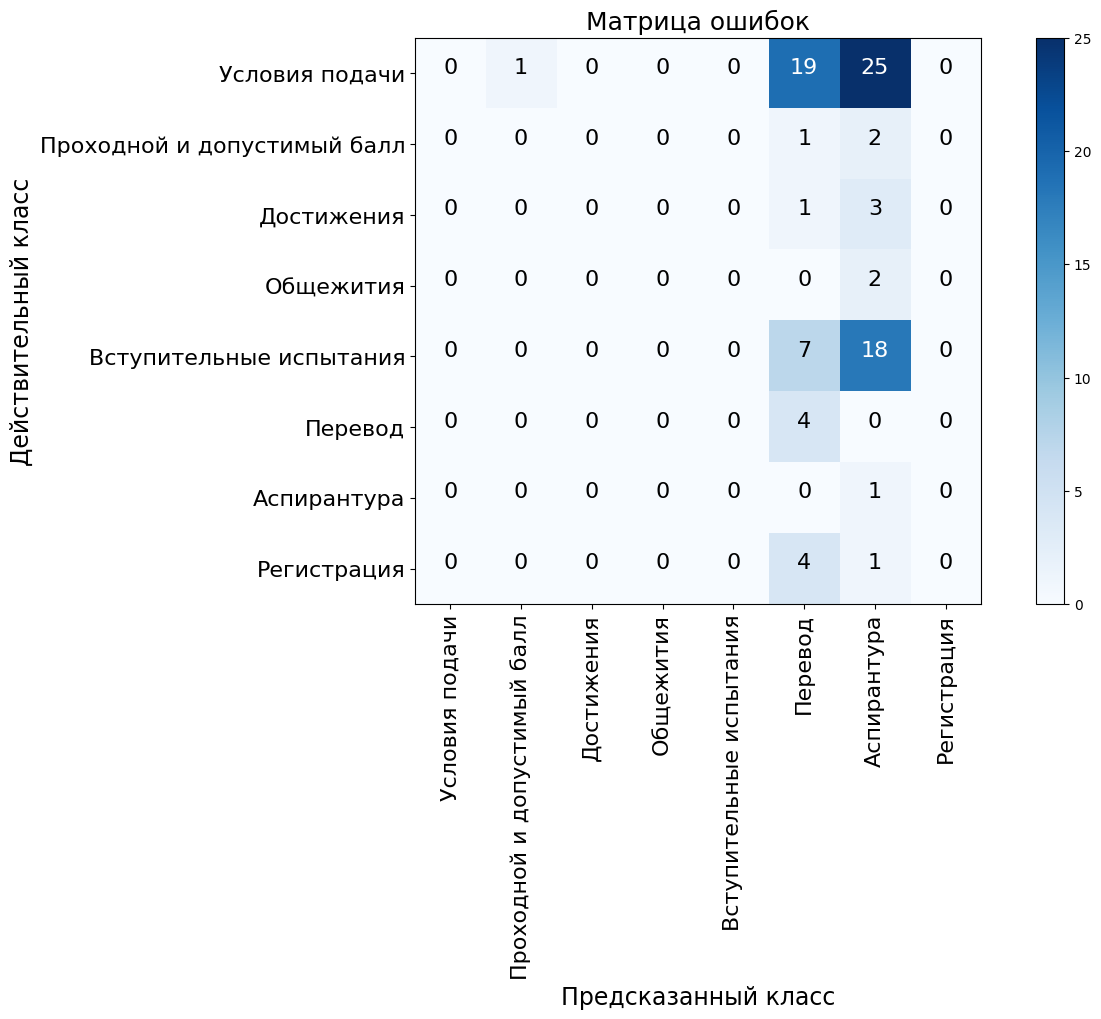

In [96]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='linear'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.3189 - loss: 2.1595 - val_accuracy: 0.5000 - val_loss: 1.9600
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4789 - loss: 1.8836 - val_accuracy: 0.5000 - val_loss: 1.6472
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5074 - loss: 1.5888 - val_accuracy: 0.5000 - val_loss: 1.5015
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4536 - loss: 1.5116 - val_accuracy: 0.5000 - val_loss: 1.4456
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5143 - loss: 1.4022 - val_accuracy: 0.5341 - val_loss: 1.3943
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5580 - loss: 1.4082 - val_accuracy: 0.5909 - val_loss: 1.3174
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6421 - loss: 1.2037 - val_accuracy: 0.6591 - val_loss: 1.2078
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6906 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

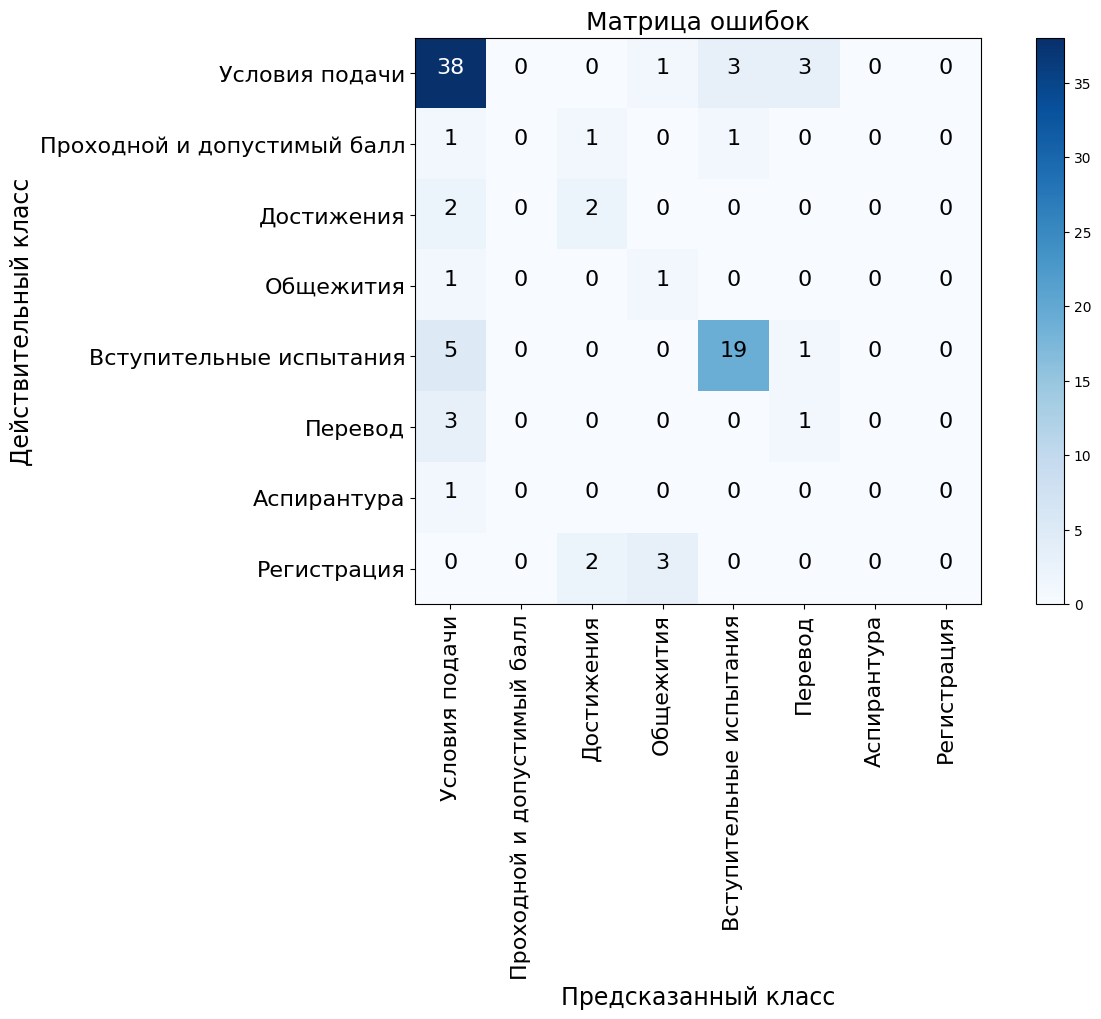

In [97]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 0.1995 - loss: 7.2944 - val_accuracy: 0.0909 - val_loss: 3.8382
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.1124 - loss: 5.1085 - val_accuracy: 0.0000e+00 - val_loss: 5.7874
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0695 - loss: 8.2447 - val_accuracy: 0.0227 - val_loss: 10.4452
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0616 - loss: 9.8544 - val_accuracy: 0.1364 - val_loss: 10.0676
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.1559 - loss: 8.9655 - val_accuracy: 0.2727 - val_loss: 9.9476
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2398 - loss: 8.9185 - val_accuracy: 0.2727 - val_loss: 8.7083
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2390 - loss: 8.3118 - val_accuracy: 0.2727 - val_loss: 8.5314
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

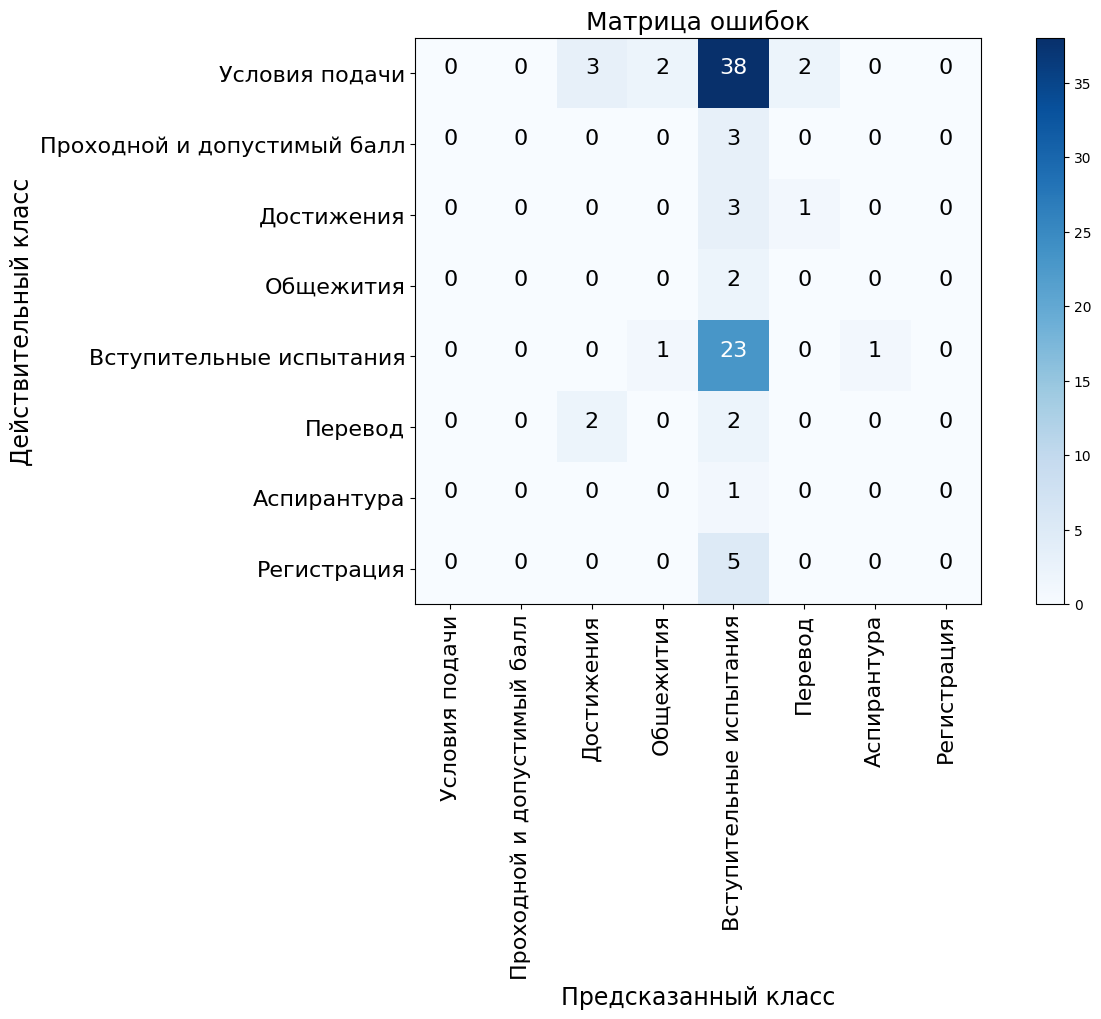

In [98]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='swish'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.3328 - loss: 1.0011 - val_accuracy: 0.5682 - val_loss: 0.9987
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6477 - loss: 0.9972 - val_accuracy: 0.6477 - val_loss: 0.9950
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6860 - loss: 0.9916 - val_accuracy: 0.6136 - val_loss: 0.9813
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5879 - loss: 0.9627 - val_accuracy: 0.5114 - val_loss: 0.8894
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5308 - loss: 0.8808 - val_accuracy: 0.6136 - val_loss: 0.7597
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6348 - loss: 0.7365 - val_accuracy: 0.6591 - val_loss: 0.7261
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7248 - loss: 0.6474 - val_accuracy: 0.6591 - val_loss: 0.6486
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6867 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

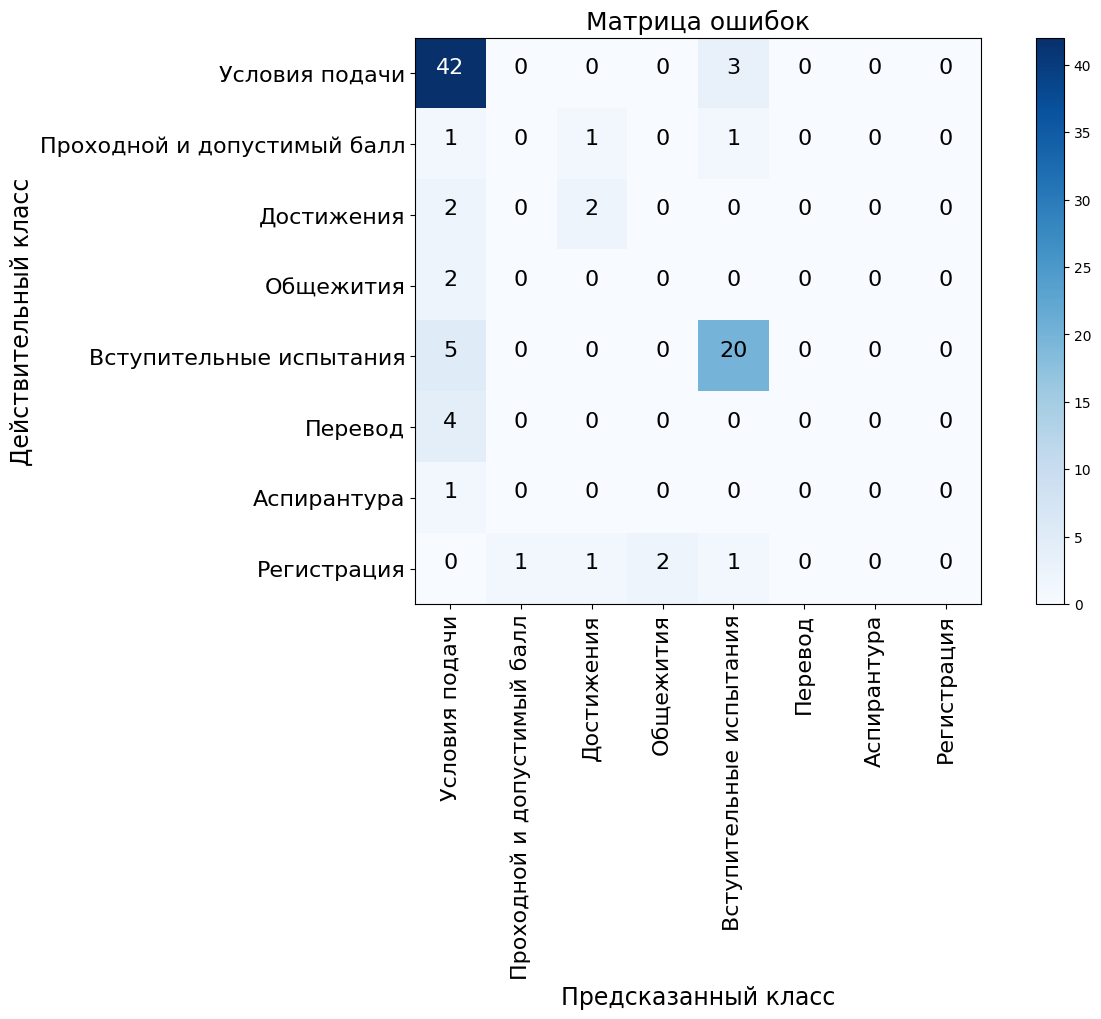

In [99]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.3216 - loss: -0.3464 - val_accuracy: 0.5000 - val_loss: -0.4275
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4915 - loss: -0.4703 - val_accuracy: 0.5000 - val_loss: -0.5780
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5169 - loss: -0.5830 - val_accuracy: 0.5000 - val_loss: -0.5884
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4763 - loss: -0.5667 - val_accuracy: 0.5000 - val_loss: -0.6007
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5182 - loss: -0.5933 - val_accuracy: 0.5682 - val_loss: -0.6226
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6228 - loss: -0.6360 - val_accuracy: 0.6250 - val_loss: -0.6538
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6955 - loss: -0.6847 - val_accuracy: 0.6705 - val_loss: -0.6853
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - acc

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

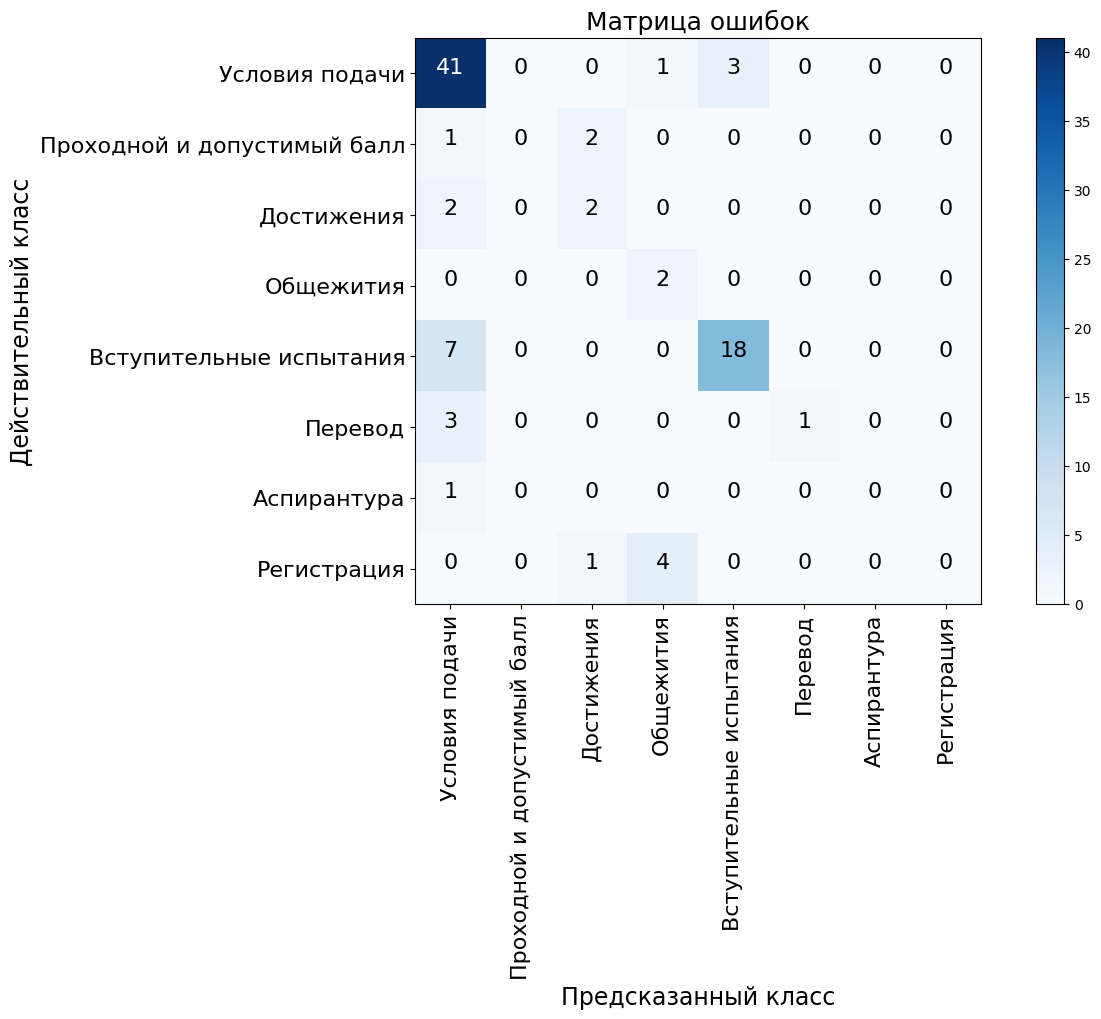

In [100]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='cosine_similarity',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.3823 - loss: 1.0012 - val_accuracy: 0.5568 - val_loss: 0.9988
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5707 - loss: 0.9967 - val_accuracy: 0.5795 - val_loss: 0.9949
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5906 - loss: 0.9899 - val_accuracy: 0.6023 - val_loss: 0.9834
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5594 - loss: 0.9641 - val_accuracy: 0.5568 - val_loss: 0.9113
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5127 - loss: 0.8778 - val_accuracy: 0.6364 - val_loss: 0.8409
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6316 - loss: 0.7341 - val_accuracy: 0.6705 - val_loss: 0.7590
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7124 - loss: 0.6513 - val_accuracy: 0.6477 - val_loss: 0.7097
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7449 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

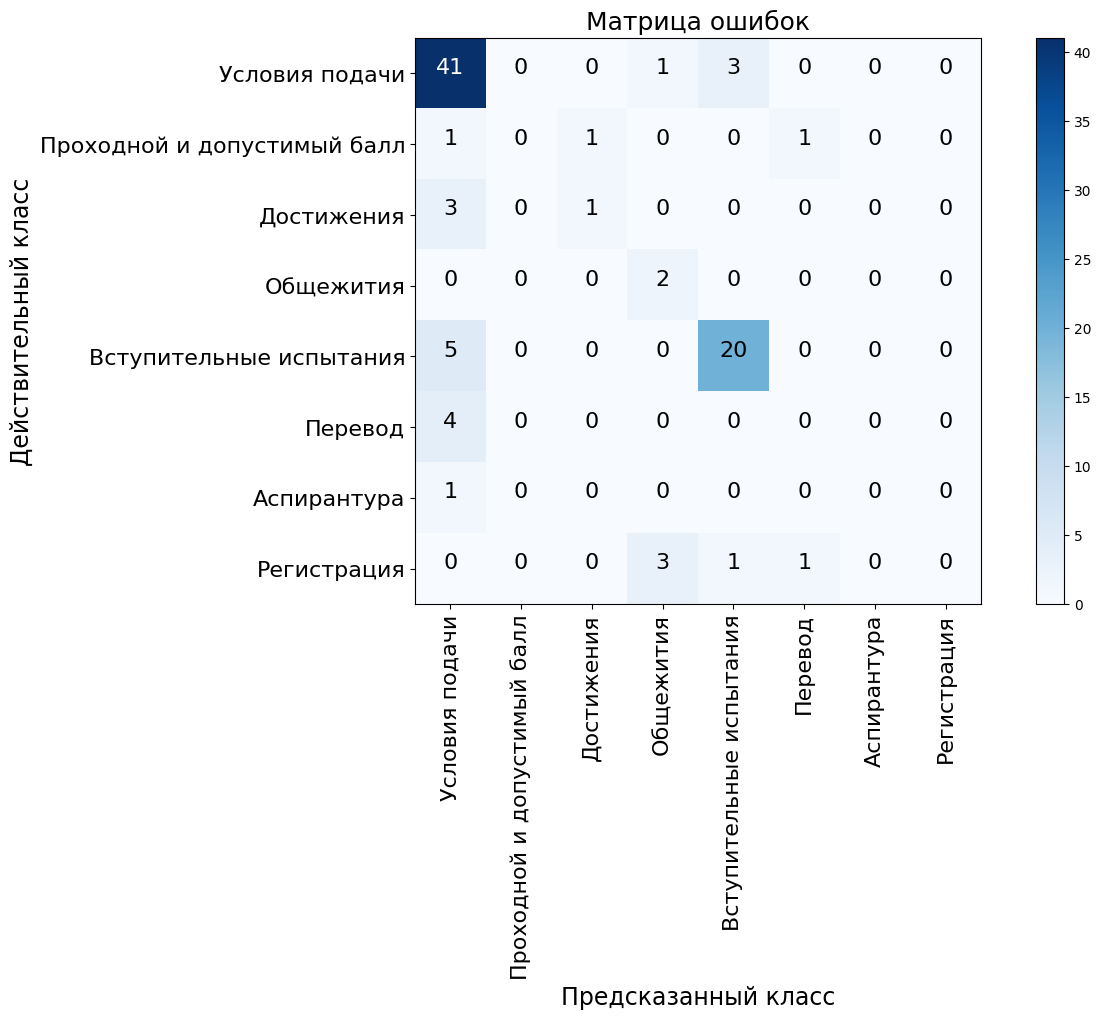

In [101]:
from keras.layers import GRU
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(GRU(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

In [102]:
%pip install xgboost
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost # подключим библиотеку XGboost

Y_train = np.argmax(y_train, axis=1)-1
Y_test = np.argmax(y_test, axis=1)-1

estimators = [('RandomForestClassifier', RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             max_features=2)),
              ('XGBClassifier', xgboost.XGBClassifier()),
              ('Tree', DecisionTreeClassifier(max_depth=5))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, Y_train)  # Обучение
y_pred = clf.predict(X_test)+1 # Предсказание классов тестовых данных
y2 = np.array(y_test_1.to_list())
pred2 = np.array(y_pred)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

  Using cached xgboost-2.1.3-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.3-py3-none-win_amd64.whl (124.9 MB)
Note: you may need to restart the kernel to use updated packages.


d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get

AttributeError: 'super' object has no attribute '__sklearn_tags__'